In [4]:
!pip install keras-tcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 83.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 148.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 148.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 143.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 161.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


In [8]:
from tcn import TCN
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import dump
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K

In [3]:
X_train = pd.read_csv("../../../Split Data/Training Dataset/X_train #2.csv").drop(columns=["Unnamed: 0"])
y_train = pd.read_csv("../../../Split Data/Training Dataset/y_train #2.csv", index_col=0)
X_val = pd.read_csv("../../../Split Data/Validation Dataset/X_val #2.csv").drop(columns=["Unnamed: 0"])
y_val = pd.read_csv("../../../Split Data/Validation Dataset/y_val #2.csv", index_col=0)
X_test = pd.read_csv("../../../Split Data/Testing Dataset/X_test #2.csv").drop(columns=["Unnamed: 0"])
y_test = pd.read_csv("../../../Split Data/Testing Dataset/y_test #2.csv", index_col=0)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)   
X_test_scaled = scaler.transform(X_test) 

joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [60]:
X_train = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)  
X_val = np.array(X_val_scaled).reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)  
X_test = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)  

In [27]:
num_classes = 2   
kernel_size = 5
dilations = [4, 8, 16, 32, 64] 
max_len = X_train.shape[1] 
dropout_rate = 0.05

In [28]:
inputs = Input(shape=(max_len, 1))

In [29]:
tcn = TCN(
    nb_filters= 128,
    nb_stacks = 2,
    kernel_size=kernel_size,
    dilations=dilations,
    dropout_rate=dropout_rate,
    use_layer_norm=True,
    return_sequences = True
)(inputs)

In [61]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [31]:
max_pooling = GlobalMaxPooling1D()(tcn)

In [32]:
avg_pooling = GlobalAveragePooling1D()(tcn)

In [33]:
pooling = Concatenate()([max_pooling, avg_pooling])

In [34]:
dense1 = Dense(64, activation= 'relu')(pooling)

In [35]:
dropout1 = Dropout(0.2)(dense1)

In [36]:
outputs = Dense(2, activation='softmax')(dropout1)

In [4]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [38]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 15, 1)]              0         []                            
                                                                                                  
 tcn_2 (TCN)                 (None, 15, 128)              1565056   ['input_2[0][0]']             
                                                                                                  
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['tcn_2[0][0]']               
 obalMaxPooling1D)                                                                                
                                                                                                  
 global_average_pooling1d_1  (None, 128)                  0         ['tcn_2[0][0]']         

In [62]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

y_train shape: (8001, 2)
y_val shape: (1714, 2)


In [63]:
history = model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val), verbose = 1, 
          callbacks = 
          ModelCheckpoint(filepath="TCN #2.h5", 
          monitor='val_f1', mode='max',save_best_only=True))

Epoch 1/100
  1/251 [..............................] - ETA: 11s - loss: 0.3662 - accuracy: 0.8125 - f1: 0.8125

251/251 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9100 - f1: 0.9104

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 10s 38ms/step - loss: 0.2410 - accuracy: 0.9100 - f1: 0.9104 - val_loss: 0.2837 - val_accuracy: 0.9037 - val_f1: 0.9036
Epoch 2/100
251/251 [==============================] - 9s 38ms/step - loss: 0.2397 - accuracy: 0.9116 - f1: 0.9120 - val_loss: 0.2723 - val_accuracy: 0.9067 - val_f1: 0.9065
Epoch 3/100
251/251 [==============================] - 9s 37ms/step - loss: 0.2336 - accuracy: 0.9124 - f1: 0.9127 - val_loss: 0.2798 - val_accuracy: 0.9049 - val_f1: 0.9048
Epoch 4/100
251/251 [==============================] - 9s 35ms/step - loss: 0.2378 - accuracy: 0.9126 - f1: 0.9130 - val_loss: 0.2684 - val_accuracy: 0.9043 - val_f1: 0.9042
Epoch 5/100
251/251 [==============================] - 9s 36ms/step - loss: 0.2367 - accuracy: 0.9124 - f1: 0.9127 - val_loss: 0.3030 - val_accuracy: 0.9026 - val_f1: 0.9025
Epoch 6/100
251/251 [==============================] - 9s 36ms/step - loss: 0.2368 - accuracy: 0.9146 - f1: 0.9150 - val_loss: 0.2718 - val_a

In [7]:
TCN_model = load_model('TCN #2.h5', custom_objects={'f1': f1})

2025-04-24 14:50:08.468290: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


ValueError: Shape mismatch in layer #0 (named tcn_2)for weight tcn_2/residual_block_0/conv1D_0/kernel. Weight expects shape (5, 1, 128). Received saved weight with shape (128,)

In [65]:
y_test = to_categorical(y_test, 2)

In [66]:
results = TCN_model.evaluate(X_test, y_test, verbose = 1)

54/54 [==============================] - 2s 17ms/step - loss: 0.3120 - accuracy: 0.8968 - f1: 0.8968


In [67]:
y_pred = TCN_model.predict(X_test)

54/54 [==============================] - 2s 16ms/step


In [68]:
y_test = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

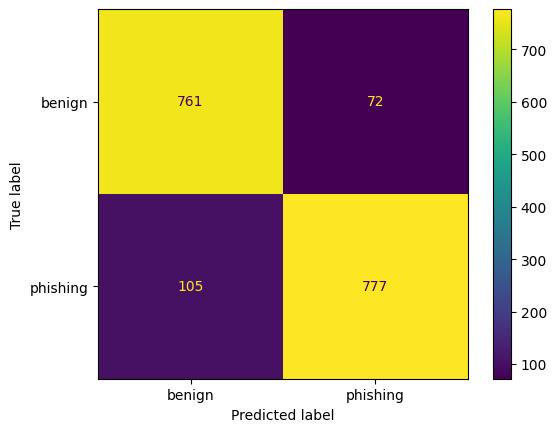

In [71]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["benign", "phishing"])                            
matrix.plot()

In [72]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
F1_score = metrics.f1_score(y_test, y_pred)

In [73]:
print({"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"F1_score":F1_score})

{'Accuracy': 0.8967930029154519, 'Precision': 0.9151943462897526, 'Recall': 0.8809523809523809, 'F1_score': 0.8977469670710573}


In [75]:
df = pd.read_csv("../Metrics of Dataset #2.csv")

In [76]:
metrics = pd.DataFrame({"Model": "TCN", "Accuracy": [Accuracy], "Precision":[Precision], "Recall": [Recall], "F1_score": [F1_score]})

In [77]:
df = pd.concat([df, metrics], ignore_index=True)

In [78]:
df.head()

,Model,Accuracy,Precision,Recall,F1_score
0,LinearSVC,0.869388,0.859170,0.892290,0.875417
1,Random Forest,0.900875,0.913953,0.891156,0.902411
2,XGBoost,0.895044,0.892617,0.904762,0.898649
3,MLP,0.896210,0.893736,0.905896,0.899775
4,TCN,0.896793,0.915194,0.880952,0.897747


In [79]:
df.to_csv("../Metrics of Dataset #2.csv", index=False)